Steven Jonathan

In [73]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Dropout

In [74]:
df_Test = pd.read_csv('/content/DailyDelhiClimateTest.csv')
df_Train = pd.read_csv('/content/DailyDelhiClimateTrain.csv')

In [75]:
df_Train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [76]:
df_Test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [77]:
df_Train.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [78]:
df_Test.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

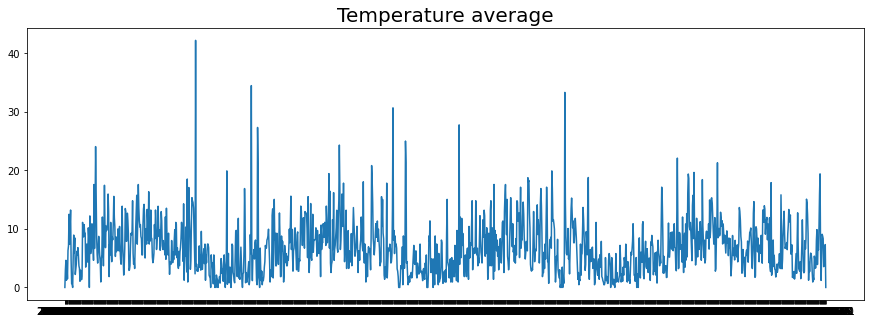

In [79]:
date = df_Train['date'].values
wind_speed  = df_Train['wind_speed'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(date, wind_speed)
plt.title('Temperature average',
          fontsize=20);

In [80]:
from sklearn.model_selection import train_test_split

x_train, x_test , y_train, y_test  = train_test_split(wind_speed, date, test_size=0.2)
print("Jumlah Dataset Train: ", len(x_train))
print("Jumlah Dataset Test: ", len(x_test))

Jumlah Dataset Train:  1169
Jumlah Dataset Test:  293


In [81]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [82]:
train_set = windowed_dataset(x_train, window_size=64, batch_size=200, shuffle_buffer=1000)
val_set = windowed_dataset(x_test, window_size=64, batch_size=200, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
    Bidirectional(LSTM(60, return_sequences=True)),
    Bidirectional(LSTM(60)),
    Dense(30, activation="relu"),
    Dense(10, activation="relu"),
    Dense(1),
])

In [83]:
Mae = (df['wind_speed'].max() - df['wind_speed'].min()) * 10/100
print(Mae)

1.7926785714285713


In [84]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<1.79 and logs.get('val_mae')<1.79):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [85]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, validation_data = val_set, callbacks=[callbacks])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


6/6 [==============================] - 12s 841ms/step - loss: 6.5022 - mae: 6.9943 - val_loss: 6.1162 - val_mae: 6.6122
Epoch 2/100
6/6 [==============================] - 3s 433ms/step - loss: 6.4696 - mae: 6.9609 - val_loss: 6.0738 - val_mae: 6.5693
Epoch 3/100
6/6 [==============================] - 3s 436ms/step - loss: 6.4282 - mae: 6.9186 - val_loss: 6.0374 - val_mae: 6.5323
Epoch 4/100
6/6 [==============================] - 3s 429ms/step - loss: 6.3952 - mae: 6.8845 - val_loss: 6.0090 - val_mae: 6.5034
Epoch 5/100
6/6 [==============================] - 3s 428ms/step - loss: 6.3706 - mae: 6.8594 - val_loss: 5.9920 - val_mae: 6.4864
Epoch 6/100
6/6 [==============================] - 3s 428ms/step - loss: 6.3565 - mae: 6.8453 - val_loss: 5.9832 - val_mae: 6.4776
Epoch 7/100
6/6 [==============================] - 3s 424ms/step - loss: 6.3470 - mae: 6.8358 - val_loss: 5.9734 - val_mae: 6.4678
Epoch 8/100
6/6 [==============================] - 3s 425ms/step - loss: 6.3364 - mae: 6.8253 

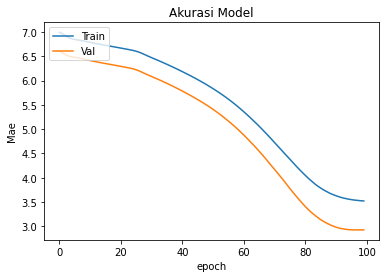

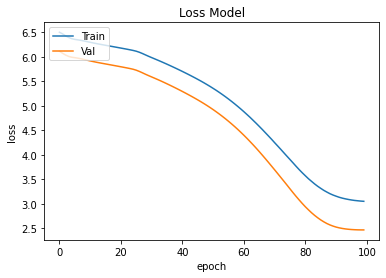

In [86]:
# Plot Accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()